## <center> Homework 6 </center>
<center> Tara Wilson </center>
<center> DATA 558 </center>
<center> May 17, 2019 </center>

In [2]:
# imports
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import os
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.linalg import eigh
from IPython.display import Image
from numpy.linalg import inv
import random
import warnings
warnings.filterwarnings('ignore')

### Exercise 1

**In this exercise, you will implement in Python a first version of your own coordinate descent algorithm to solve the LASSO problem, that is the $l_1$-regularized least-squares regression problem.**  

**Recall from the lectures that the LASSO problem writes as**:  
$min F(\beta) := \frac {1}{n} \sum_{i=1}^{n} (y_i - x_i^T \beta)^2 + \lambda ||\beta||_1$  

#### Coordinate Descent  

**The coordinate descent algorithm is outlined in Algorithm 1. The algorithm requires a subroutine that performs the partial minimization of the objective for any coordinate $\beta_j$.**

**Assume that d = 1 and n = 1. The sample is then of size 1 and boils down to just $(x, y)$; the learning parameter β is then a scalar. The function F writes simply as**  
$F(\beta) = (y - x\beta)^2 + \lambda |\beta|$.  
**The solution to the minimization problem $min F(\beta)$ is given in Slide 71 of the Week 5 Lecture. Write a function that computes the formula
of the solution of this minimization problem.**

Coordinate minimization for lasso with n = 1 and d = 1:  

$\beta_j = argmin (y - x\beta)^2 + \lambda |\beta|$  

The derivative of this then gives us:  
$\beta_j = -2x(y - x\beta) +- \lambda$

With the following cases:  
$\begin{equation}
\beta_j (c_j) = \begin{cases}
    +1 \text{    if    } \beta_j > 0 \\  
    -1 \text{    if    } \beta_j < 0 \\  
    [-1, 1] \text{    if    } \beta_j = 0  
    \end{cases}
\end{equation}$

In [29]:
def minimizeBetaSimpleCase(x, y, lamb, beta):
    firstTerm = -2 * x *(y - x * beta)
    # should this be the derivative??????????
    if (beta > 0):
        return firstTerm + lamb
    elif (beta < 0):
        return firstTerm - lamb
    else:
        # randomly pick -1 or 1
        sign = random.randint(0, 1)
        if (sign == 1):
            return firstTerm + lamb
        else:
            return firstTerm - lamb
    
#minimizeBetaSimpleCase(np.array((3, 2)), 1, .1, 3)

**Assume now that d > 1 and n > 1. The full minimization problem now writes as**  
  
$F(\beta) := \frac {1}{n} \sum_{i=1}^{n} (y_i - x_i^T \beta)^2 + \lambda ||\beta||_1$  

**Coordinate descent proceeds by sequential partial minimization with respect to each coordinate βj, that by solving partial minimization problems of form**  
  
$min \frac{1}{n} \sum_{i=1}^{n} (y_i - ({\beta_1x_{i,1} + ... + \beta_jx_{i,j} + ... + \beta_dx_{i,d}}))^2 + \lambda (|\beta_1| + ... + |\beta_j| + ... + |\beta_d|)$   

**Write a function that computes the formula of the solution of this partial minimization problem with respect to $\beta_j$ for any j = 1, . . . , d.**

Coordinate minimization for lasso with n > 1 and d > 1:  

$\beta_j = argmin \frac {1}{n} \sum_{i=1}^{n} (\beta^T x_i - y_i)^2 + \lambda ||\beta||_1$  

Then:  
$\begin{equation}
\beta_j (c_j) = \begin{cases}
    \frac{c_j + \lambda}{a_j} \text{    if    } c_j < -\lambda \\  
    0 \text{    if    } c_j \in [\lambda, -\lambda] \\  
    \frac{c_j - \lambda}{a_j} \text{    if    } c_j > \lambda   
    \end{cases}
\end{equation}$

Where:  
$a_j = \frac{2}{n} \sum_{i=1}^{n} x_{i,j}^2$  
$c_j = \frac{2}{n} \sum_{i=1}^{n} x_{i,j} (y_i - \beta^T_{-j} x_{i,-j}$  
and $\beta_{-j}$ is $\beta$ without component $j$ and similarly for $x_{i,-j}$


In [30]:
def minimizeBeta(X, y, jIndex, lamb, betas):
    betaJ = betas[jIndex]
    xJ = X[jIndex]
    betasMinusJ = np.delete(betas, jIndex)
    aj = 0
    cj = 0
    n = len(X)
    for i in range(0, n):
        xi = X[i, :]
        xIMinusJ = np.delete(xi, jIndex)     
        aj += (X[i, jIndex])**2
        cj += (X[i, jIndex])*(y[i] - betasMinusJ.T.dot(xIMinusJ))
    aj = (2/n) * aj
    cj = (2/n) * cj
    if (cj < -lamb):
        return ((cj + lamb)/ aj)
    elif (cj > lamb):
        return ((cj - lamb)/ aj)
    else:
        return 0

**Consider the `Hitters` dataset from [1].  Standardize
the data, i.e., center the features and divide them by their standard deviation, and center the outputs. For any categorical variables you should first convert them to indicator variables and then perform the standardization.**

In [31]:
# read in Hitters data
hitters = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv", sep=",", header=0)
hitters = hitters.dropna()

# Categorical Variables = League, Division, and NewLeague
dataTypes = hitters.dtypes

# Converts categorical data columns to indicator variables
hitters = pd.get_dummies(hitters, columns=["League", "Division", "NewLeague"], prefix = ["League", "Division", "NewLeague"])
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,1,0,0,1,1,0


In [32]:
# seperate X and y
X = hitters.drop("Salary", axis=1)
#X = pd.get_dummies(X, drop_first=True)
y = hitters["Salary"]

# Divide the data into training and test sets. By default, 25% goes into the test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [33]:
#converting data into arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train).reshape(197, 1)
y_test = np.array(y_test).reshape(66, 1)

# standardizing X by subtracting the mean of the predictors and dividing by their standard deviation
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# standardizing Y by subtracting the mean of the predictors and dividing by their standard deviation
scaler = preprocessing.StandardScaler().fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (197, 22)
Shape of X_test:  (66, 22)
Shape of y_train:  (197, 1)
Shape of y_test:  (66, 1)


**Write a function *computeobj* that computes and returns $F(\beta)$ for any $\beta$**

In [34]:
def computeobj(X, y, beta, lamb):
    """
    Computes the objective for the l1-regularized least-squares regression problem
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes
        - beta: vector of beta constants
        - lambda: scalar multiplicative factor for regularization penalty
    Outputs:
        - objective for passed in parameters
    """
    n = len(X)
    summation = 0
    for i in range(0, n):
        xi = X[i,:]
        yi = y[i]
        iTerm = (yi - xi.T.dot(beta))**2
        summation = summation + iTerm
    return (((1/n) * summation) + lamb * np.linalg.norm(beta, ord=1))

**Write a function *cycliccoorddescent* that implements the *cyclic coordinate descent* algorithm. The cyclic coordinate descent algorithm proceeds sequentially. At each iteration, the algorithm increments the index $j_t$ of the coordinate to minimize over. Then the algorithm performs partial minimization with respect to the coordinate $\beta_{jt}$ corresponding to that index. After updating the coordinate $\beta_{jt}$, the algorithm proceeds to the next iteration. The function takes as input the initial point and the maximum number of iterations. The stopping criterion is the maximum number of iterations.**

In [35]:
def cycliccoorddescent(X, y, beta, lamb, maxIter):
    """
    """
    objs = [computeobj(X, y, beta, lamb)]
    betas = [beta]
    t = 0
    while (t < maxIter):
        for j in range(0, X.shape[1]):
            beta[j] = minimizeBeta(X, y, j, lamb, beta)
            betas.append(beta) # saves current beta values
            obj = computeobj(X, y, beta, lamb)
            objs.append(obj) # saves current objective value
            t += 1
    return np.array(betas), np.array(objs)

**Write a function *pickcoord* that samples uniformly from the set {1, . . . , d}.**

In [36]:
def pickcoord(d):
    """
    Uniformly selects a value from the set {1, ..., d}
    Inputs:
        - d: the maximum value to uniformly select from
    Outputs:
        - a random integer between 1 and d
    """
    return random.randint(1, d)

**Write a function *randcoorddescent* that implements the *randomized coordinate descent* algorithm. The randomized coordinate descent algorithm proceeds as follows. At each iteration, the algorithm samples the index $j_t$ of the coordinate to minimize over. Then the algorithm performs partial minimization with respect to the coordinate $\beta_{jt}$ corresponding to that index. After updating the coordinate $\beta_{jt}$, the algorithm proceeds to the next iteration. The function takes as input the initial point and the maximum number of iterations. The stopping criterion is the maximum number of iterations.**

In [37]:
def randcoorddescent(X, y, beta, lamb, maxIter):
    """
    """
    objs = [computeobj(X, y, beta, lamb)]
    betas = [beta]
    t = 0
    while (t < maxIter):
        j = pickcoord(X.shape[1]) - 1 # subtract one to scale for 0-based indexing
        beta[j] = minimizeBeta(X, y, j, lamb, beta)
        betas.append(beta) # saves current beta values
        obj = computeobj(X, y, beta, lamb)
        objs.append(obj) # saves current objective value
        t += 1
    return np.array(betas), np.array(objs)

**Set the maximum number of iterations to 1000. In the remainder, the iteration counter iter refers here to $\frac{t}{d}$, that is the effective number of passes over all coordinates. Run cross-validation on the training set of the `Hitters` dataset using scikit-learn to find the optimal value of λ. Run *cycliccoorddescent* and *randcoorddescent* on the training set of the Hitters dataset for that value of λ found by cross-validation. Plot the curves of the objective values $F(\beta_t)$ for both algorithms versus the iteration counter iter (use different colors). What do you observe?**

In [50]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV


lasso = Lasso(alpha = 1.2, random_state=0, max_iter=1000)
lasso.fit(X_train, y_train)
param_grid = {'alpha': [0.001, 0.05, 0.01, .5, 0.1, .5, 1, 5, 10, 50, 100, 500, 1000] }
clf = GridSearchCV(lasso, param_grid, cv=5, refit=True)
newLamb = clf.fit(X_train, y_train).get_params()
newLamb

{'cv': 5,
 'error_score': 'raise-deprecating',
 'estimator__alpha': 1.2,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__max_iter': 1000,
 'estimator__normalize': False,
 'estimator__positive': False,
 'estimator__precompute': False,
 'estimator__random_state': 0,
 'estimator__selection': 'cyclic',
 'estimator__tol': 0.0001,
 'estimator__warm_start': False,
 'estimator': Lasso(alpha=1.2, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=0,
    selection='cyclic', tol=0.0001, warm_start=False),
 'fit_params': None,
 'iid': 'warn',
 'n_jobs': None,
 'param_grid': {'alpha': [0.001,
   0.05,
   0.01,
   0.5,
   0.1,
   0.5,
   1,
   5,
   10,
   50,
   100,
   500,
   1000]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': 'warn',
 'scoring': None,
 'verbose': 0}

In [54]:
# set constants
lamb = .01 # figure this out!!!!!
maxIter = 1000

cyclicBetas, cyclicObjs = cycliccoorddescent(X_train, y_train, np.zeros((X.shape[1], 1)), lamb, maxIter)
randBetas, randObjs = randcoorddescent(X_train, y_train, np.zeros((X.shape[1], 1)), lamb, maxIter)

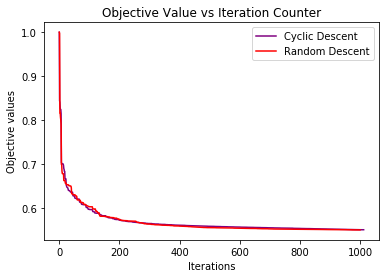

In [55]:
# plot objective values to verify they are decreasing properly
plt.plot(cyclicObjs, color = "purple")
plt.plot(randObjs, color = "red")
plt.ylabel("Objective values")
plt.xlabel("Iterations")
plt.legend(["Cyclic Descent", "Random Descent"])
plt.title("Objective Value vs Iteration Counter")
plt.show()

TALK ABOUT THIS!!!

**Denote by $\beta_T$ the final iterates of your coordinate descent algorithms for that value of λ. Compute $\beta^*$ found by *scikit-learn* for that value of λ. Plot the curves of the fraction of correct non-zero coefficients (with respect to $\beta^*$) for both algorithms versus the iteration counter iter (use different colors). What do you observe? Plot the curves of the fraction of correct zero coefficients for both algorithms (with respect to $\beta^*$) versus the iteration counter `iter` (use different colors). What do you observe?**

In [93]:
# ThiS IS WRONG FIX THIS!!!!!!!!!
def fractionNonZero(betas):
    fractionNonZero = []
    for beta in betas:
        count = len(beta)
        for val in beta:
            if(val == 0):
                count -= 1
        fractionNonZero.append(count / len(beta))
    return fractionNonZero

In [94]:
randFractionNonZero = fractionNonZero(randBetas)
cyclicFractionNonZero = fractionNonZero(cyclicBetas)

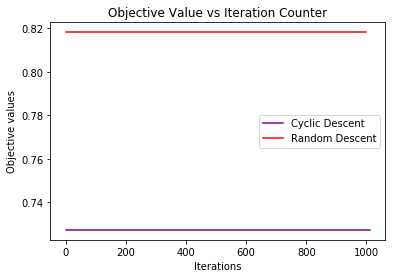

In [96]:
# plot fraction of non-0 betas per iteration
plt.plot(cyclicFractionNonZero, color = "purple")
plt.plot(randFractionNonZero, color = "red")
plt.ylabel("F")
plt.xlabel("Iterations")
plt.legend(["Cyclic Descent", "Random Descent"])
plt.title("Objective Value vs Iteration Counter")
plt.show()

### Exercise 2

**In this problem you will generate simulated data and then perform PCA on the data. You will use your own normalized Oja algorithm for PCA. Note that “first two principal component score vectors” refers to the results from projecting the original data to a two-dimensional space with PCA.**

**(a) Generate a simulated data set with 30 observations in each of three classes (i.e. 90 observations total), and 60 features. Hint: There are a number of functions in numpy that you can use to generate data. One example is the `numpy.random.normal()` function; `numpy.random.uniform()` is another option. Be sure to add a mean shift to the observations in each class so that there are three distinct classes.**

In [62]:
# generate random samples
x1 = np.random.normal(loc=10.0, scale=5.0, size=[30, 60])
x2 = np.random.normal(loc=20.0, scale=5.0, size=[30, 60])
x3 = np.random.normal(loc=-10.0, scale=5.0, size=[30, 60])

X = np.vstack((x1, x2, x3))

**(b) Run *your own normalized Oja algorithm* on the 90 observations. This algorithm was discussed in the week 8 lecture. Plot the first two principal component score vectors. Compare your results to the ones obtained with scikit-learn’s PCA algorithm. Use a different color to indicate the observations in each of the three classes. If the three
classes appear separated in this plot, then you’re done. If not, then return to part (a) and modify the simulation so that there is greater separation between the three classes.**

In [ ]:
def oja(X, eta):
    eigenVals, eigenVectors = np.linalg.eig(X)
    # standardize??
    # pick randomly eigenvector w^(0) so that ||w^(0)||_2 = 1
    #Iterate:
        # Update w^t+1 = w^t + eta * x_t * x_t^T*w^T
        # Normalize file:///C:/Users/wwtar/Downloads/data558_s19_week7.pdf pg 69

In [ ]:
# calculate first two principal component score vectors with Oja


In [ ]:
# plot Oja algorithm first two principal components


In [63]:
# scikit learn PCA to get components
pca = PCA(n_components=60)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=60, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

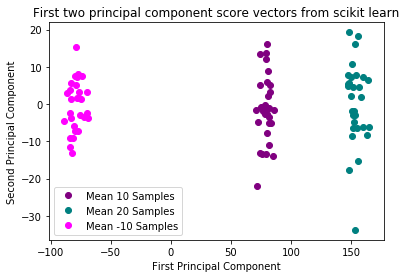

In [64]:
# add scikit learn PCA to plot
pcaProj1 = -pca.components_[0].T.dot(X.T)
pcaProj2 = -pca.components_[1].T.dot(X.T)

plt.plot(pcaProj1[0:30], pcaProj2[0:30], 'o', color="purple")
plt.plot(pcaProj1[30:60], pcaProj2[30:60], 'o', color="teal")
plt.plot(pcaProj1[60:90], pcaProj2[60:90], 'o', color="magenta")

plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend(["Mean 10 Samples", "Mean 20 Samples", "Mean -10 Samples"])
plt.title("First two principal component score vectors from scikit learn")
plt.show()

TALK ABOUT ThiS

### Exercise 3

**In this exercise, we will generate simulated data, and will then use this data to fit a lasso model. You should use Scikit-learn in this exercise for fitting the lasso model and performing cross-validation.**

**(a) Use the `numpy.random.normal()` function to generate a predictor X of length n = 100, as well as a noise vector $\epsilon$ of length n = 100.**

In [52]:
# generate X values
X = np.random.normal(loc=0, scale=1, size=[100, 1])

# generate noise vector
epsilon = np.random.normal(loc=0, scale=1, size=[100, 1])

**(b) Generate a response vector Y of length n = 100 according to the model  
$Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon$  
where $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ are constants of your choice. Here superscripts denote powers of X.**

In [53]:
# choose values for constants
beta0 = 0.17
beta1 = 0.63
beta2 = -0.95
beta3 = -.33

# fit lasso modal
Y = beta0 + beta1 * X + beta2 * (X**2) + beta3 * (X**3) + epsilon

print("Shape of response vector y: ", Y.shape)

Shape of response vector y:  (100, 1)


**(c) Now fit a lasso model to the simulated data, using $X$, $X^2$, ..., $X^{10}$ as predictors. Use cross-validation to select the optimal value of λ. Create plots of the cross-validation error as a function of λ. Report the resulting coefficient estimates, and discuss the results obtained.**

In [60]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha = 0.1, fit_intercept = True, max_iter=1000)
clf.fit(X, Y)

clf.coef_

array([-0.])

**(d) Now generate a response vector Y according to the model  
$Y = \beta_0 + \beta_7 X^7 + \epsilon$  
and fit a lasso model. Discuss the results obtained.**

TALK ABOUT THIS!!!

### Exercise 4

**Read the announcement “Data Competition 2” on Canvas. Convert each image into a feature vector using the provided extract features.py script. We strongly recommend you perform this task on AWS.**

**Pick two classes of your choice from the dataset. Train an $l^2_2$-regularized logistic regression classifier on the training set using your own fast gradient algorithm with λ = 1. Plot, with different colors, the *misclassification error* on the training set and on the validation set vs iterations.**


In [3]:
data_dir = "../Kaggle/data558spring2019-competition2"

x_train_unfiltered = np.load(os.path.join(data_dir, 'train_features.npy'))
y_train_unfiltered = np.load(os.path.join(data_dir, 'train_labels.npy'))
x_test_unfiltered = np.load(os.path.join(data_dir, 'val_features.npy'))
y_test_unfiltered = np.load(os.path.join(data_dir, 'val_labels.npy'))

# filter testing data to two classes: 4, 7
x_train = np.zeros((1000, x_train_unfiltered.shape[1]))
y_train = np.zeros((1000, 1))
index = 0
for i in range(y_train_unfiltered.shape[0]):
    if(y_train_unfiltered[i] == 4 or y_train_unfiltered[i] == 7):
        x_train[index, :] = x_train_unfiltered[i].T
        y_train[index, :] = y_train_unfiltered[i]
        index += 1

y_train[y_train == 4] = -1
y_train[y_train == 7] = 1

# filter testing data to two classes: 4, 7
x_test = np.zeros((200, x_test_unfiltered.shape[1]))
y_test = np.zeros((200, 1))
index = 0
for i in range(y_test_unfiltered.shape[0]):
    if(y_test_unfiltered[i] == 4 or y_test_unfiltered[i] == 7):
        x_test[index, :] = x_test_unfiltered[i].T
        y_test[index, :] = y_test_unfiltered[i]
        index += 1

# reset y data to -1 and 1 to fit machine learning standards
y_test[y_test == 4] = -1
y_test[y_test == 7] = 1

# combine test and validation data for this exercise
xTrain = np.vstack((x_test, x_train))
yTrain = np.vstack((y_test, y_train))
xScaler = preprocessing.StandardScaler()
XTrain = xScaler.fit_transform(xTrain)

# check dimensions
print("Number of images in x train:", xTrain.shape[0])
print("Dimension of features:", xTrain.shape[1])

Number of images in x train: 1200
Dimension of features: 4096


In [11]:
def fastgradalgo(X, y, stepSize, targetAccuracy = 0.001, lamb = 0.05):
    """
    Implements fast gradient descent algorithm with backtracking
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes
        - stepSize: initial step size
        - targetAccuracy: target accuracy value for algorithm
        - lambda: scalar multiplicative factor for regularization penalty (optional, defaults to 0.05)
    Outputs:
        - betas: vector of improved betas after final iteration
        - objs: vector of objective values for each iteration
    """
    x = X
    beta = np.zeros((X.shape[1], 1))
    theta = np.zeros((X.shape[1], 1))
    objs = [computeobj(x, y, beta, lamb)]
    betas = [beta]
    grad = computegrad(x, y, theta, lamb)
    t = 0  # tracks iterations
    while (np.linalg.norm(grad) > targetAccuracy):
        stepSize = backtracking(x, y, beta, stepSize)
        betaOld = beta
        beta = theta - stepSize * computegrad(x, y, theta, lamb)
        theta = beta + (t/(t+3))*(beta - betaOld)
        betas.append(beta) # saves current beta values
        obj = computeobj(x, y, beta, lamb)
        objs.append(obj) # saves current objective value
        grad = computegrad(x, y, theta, lamb)
        t = t + 1
    return np.array(betas), np.array(objs)

In [12]:
def graddescent(X, y, stepSize, targetAccuracy = 0.001, lamb = 0.05):
    """
    Implements gradient descent algorithm with backtracking
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes
        - stepSize: initial step size
        - targetAccuracy: target accuracy value for algorithm
        - lambda: scalar multiplicative factor for regularization penalty (optional, defaults to 0.05)
    Outputs:
        - betas: vector of improved betas after final iteration
        - objs: vector of objective values for each iteration
    """
    x = X
    beta = np.zeros((X.shape[1], 1))
    objs = [computeobj(x, y, beta, lamb)]
    betas = [beta]
    grad = computegrad(x, y, beta, lamb)
    while (np.linalg.norm(grad) > targetAccuracy):
        stepSize = backtracking(x, y, beta, stepSize)
        beta = beta - stepSize * grad
        betas.append(beta) # saves current beta values
        obj = computeobj(x, y, beta, lamb)
        objs.append(obj) # saves current objective value
        grad = computegrad(x, y, beta, lamb)
    return np.array(betas), np.array(objs)

In [13]:
def backtracking(X, y, beta, eta, alpha = 0.5, gamma=0.8):
    """
    Implements backtracking rule
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes
        - beta: vector of beta constants
        - eta: initial step size
        - alpha: constant used to define sufficinet decrease condition
        - gamma: constant to scale step size by until condition met         
    Outputs:
        - step size
    """
    grad = computegrad(X, y, beta)  # calculates the gradient at current beta
    conditionMet = False # tracks when we find the backtracked step size
    while not conditionMet:    
        if computeobj(X, y, beta - eta*grad) < computeobj(X, y, beta) - alpha*eta*np.linalg.norm(grad)**2:
            conditionMet = True
        else:
            eta = eta * gamma            
    return eta

In [14]:
def computeobj(X, y, beta, lamb = 0.05):
    """
    Computes the objective for ridge regression problem
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes
        - beta: vector of beta constants
        - lambda: scalar multiplicative factor for regularization penalty (optional, defaults to 0.05)
    Outputs:
        - objective for passed in parameters
    """
    n = len(X)
    summation = 0
    for i in range(0, X.shape[0]):
        xi = X[i,:]
        yi = y[i]
        x = -yi*xi.dot(beta)
        if(x > 0): # avoids over or under flow errors
            a = x + 1
            logTerm = a + np.log(np.exp(-a) + np.exp(x-a))
        else:
            logTerm = np.log(1 + np.exp(x))
        summation = summation + logTerm
    return ((1/n) * summation + (lamb * np.sum(beta**2)))[0]

In [15]:
def computegrad(X, y, beta, lamb = 0.05):
    """
    Computes the gradient for the fast gradient algorithm
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes
        - beta: vector of beta constants
        - lambda: scalar multiplicative factor for regularization penalty (optional, defaults to 0.05)
    Outputs:
        - vector gradient for passed in parameters
    """
    n = len(X) 
    P = np.zeros((X.shape[0], X.shape[0]))
    for i in range(0, X.shape[0]):
        xi = X[i,:]
        yi = y[i]
        p = ((np.exp(-yi * (xi).dot(beta))) / (1 + (np.exp(-yi * (xi).dot(beta)))))
        P[i,i] = p  
    return ((-1/n) * X.T.dot(P).dot(y) + 2*lamb*beta)

In [16]:
def calcKaggleMisclassificationError(X, y, betas):
    """
    Calculates the misclassification error for a 0-9 response variable
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes, 0-9
        - betas: coefficients that correspond to X values
    Outputs:
        - misclassifications: ratio of incorrect values / total values for all betas
    """
    misclassifications = np.zeros((betas.shape[0], 1))
    for b in range(betas.shape[0]):
        betaVals = betas[b]
        incorrect = 0
        for i in range(X.shape[0]):
            prediction = np.sum(np.dot(X[i], betaVals))
            if(prediction > 0):
                prediction = 1
            else:
                prediction = -1
            if(prediction != y[i]):
                incorrect +=1
        misclassifications[b,:] = (incorrect / X.shape[0])
    return misclassifications

In [17]:
# set constants
lamb = 1.0
epsilon = 0.03

# calculate initial step size for training data
n = len(x_train)
eq = (1/n * x_train.T.dot(x_train))
eigVals = eigh(eq)[0]
trainStepSize = 1 / (max(eigVals) + lamb)

# run fast gradient algorithm for training data
trainBeta, trainObjs = fastgradalgo(x_train, y_train, stepSize = trainStepSize, targetAccuracy = epsilon, lamb = lamb)

# calculate initial step size for test data
n = len(x_test)
eq = (1/n * x_test.T.dot(x_test))
eigVals = eigh(eq)[0]
valStepSize = 1 / (max(eigVals) + lamb)

# run fast gradient algorithm for test data
valBeta, valObjs = fastgradalgo(x_test, y_test, stepSize = valStepSize, targetAccuracy = epsilon, lamb = lamb)

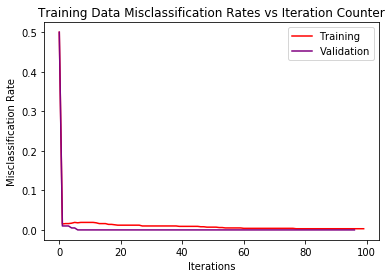

In [18]:
# calculate misclassification error on test and training set
trainMisclassification = calcKaggleMisclassificationError(x_train, y_train, trainBeta)
valMisclassification = calcKaggleMisclassificationError(x_test, y_test, valBeta)
        
# plot misclassification curves for test and training
plt.plot(trainMisclassification, color = "red")
plt.plot(valMisclassification, color = "purple")
plt.ylabel("Misclassification Rate")
plt.xlabel("Iterations")
plt.title("Training Data Misclassification Rates vs Iteration Counter")
plt.legend(["Training", "Validation"])
plt.show()

**Find the value of the regularization parameter λ using cross-validation; you may use scikit-learn’s built-in functions for this purpose. Train an $l_2^2$-regularized logistic regression classifier on the training set using your own fast gradient algorithm with that value of λ found by cross-validation. Plot, with different colors, the *misclassification error* on the training set and on the validation set vs iterations.**


In [20]:
# get scikitlearn model
model = LogisticRegression(penalty='l2', dual=False, C=1/(n*lamb), tol=epsilon, fit_intercept=False, solver="liblinear")
model = model.fit(x_train, y_train)

#cross validation to find best lambda
param_grid = {'C': [0.001, 0.05, 0.01, .5, 0.1, .5, 1, 5, 10, 50, 100, 500, 1000] }
clf = GridSearchCV(model, param_grid)
newLamb = 1/ n*(clf.fit(x_train, y_train).best_estimator_.get_params()['C'])
print("New value for lambda: ", newLamb)

New value for lambda:  5e-06


In [24]:
# calculate initial step size for training data
n = len(x_train)
eq = (1/n * x_train.T.dot(x_train))
eigVals = eigh(eq)[0]
trainStepSize = 1 / (max(eigVals) + newLamb)

# run fast gradient algorithm for training data
newTrainBeta, newTrainObjs = fastgradalgo(x_train, y_train, stepSize = trainStepSize, targetAccuracy = epsilon, lamb = newLamb)

# calculate initial step size for test data
n = len(x_test)
eq = (1/n * x_test.T.dot(x_test))
eigVals = eigh(eq)[0]
valStepSize = 1 / (max(eigVals) + newLamb)

# run fast gradient algorithm for test data
newValBeta, newValObjs = fastgradalgo(x_test, y_test, stepSize = valStepSize, targetAccuracy = epsilon, lamb = newLamb)

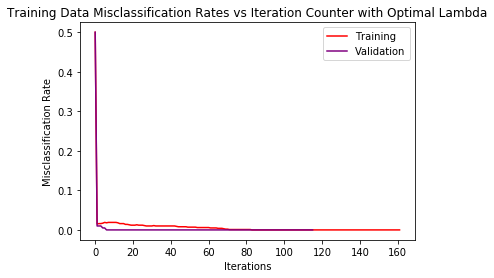

In [25]:
# calculate misclassification error on training and test set
newTrainMisclassification = calcKaggleMisclassificationError(x_train, y_train, newTrainBeta)
newValMisclassification = calcKaggleMisclassificationError(x_test, y_test, newValBeta)
        
# plot misclassification curves from new lambda value
plt.plot(newTrainMisclassification, color = "red")
plt.plot(newValMisclassification, color = "purple")
plt.ylabel("Misclassification Rate")
plt.xlabel("Iterations")
plt.title("Training Data Misclassification Rates vs Iteration Counter with Optimal Lambda")
plt.legend(["Training", "Validation"])
plt.show()

In [27]:
# create kaggle submission
kaggleTest = np.load(os.path.join(data_dir, 'test_features.npy'))
betaVals = newTrainBeta[-1]

predictions = np.zeros((kaggleTest.shape[0], 2))

for i in range(kaggleTest.shape[0]):
    prediction = np.sum(np.dot(kaggleTest[i], betaVals))
    if(prediction >= 0):
        prediction = 7
    else:
        prediction = 4
    predictions[i,:] = [i, prediction]

predictions = pd.DataFrame({"Id": predictions[:,0], "Category": predictions[:,1]})
predictions.to_csv("kaggle.csv", sep=',')